# Hyperbolic unitary cost function gradient descent SPT extraction

Created 04/11/2024

Objectives:
* Update "Unitary cost function gradient descent SPT extraction" to use a "hyperbolic" unitary cost function.
* This is mainly a poc to see if such a unitary cost function would work.

# Package imports

In [1]:
import sys
sys.path.append('../../')

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy

In [4]:
from functools import reduce 

In [5]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.utils import to_npc_array

In [6]:
import re

# Load data

In [7]:
DATA_DIR = r"../../data/transverse_cluster_200_site_dmrg"

In [8]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [9]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [10]:
psi_dict = dict()

In [11]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )

    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

# Definitions

In [12]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [13]:
symmetry_actions = [
    [np_I, np_I],
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [14]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [15]:
cases = [
    [
        SymmetryActionWithBoundaryUnitaries(
            psi,
            s*50,
            left_boundary_unitaries=[np_I,]*3,
            right_boundary_unitaries=[np_I,]*3
        )
        for s in symmetry_actions
    ]
    for psi in psi_dict.values()
]

In [16]:
for l in cases:
    for c in l:
        c.compute_svd_approximate_expectation()

In [17]:
NUM_SITES = 6

## Functions

In [18]:
P_LEG_LABEL_REGEX_STRING = r"^p\d*$"
p_leg_pattern = re.compile(P_LEG_LABEL_REGEX_STRING)

def is_single_physical_leg_label(label):
    return bool(p_leg_pattern.match(label))

In [19]:
def is_grouped_physical_leg_label(leg_label):
    head, *body, tail = leg_label
    if (head != '(') or (tail != ')'):
        return False

    body = ''.join(body)
    legs = body.split('.')

    return all(is_single_physical_leg_label(l) for l in legs)

In [20]:
def is_physical_leg_label(label):
    out = (
        is_single_physical_leg_label(label)
        or is_grouped_physical_leg_label(label)
    )

    return out

In [21]:
def extract_single_physical_leg_label_from_tensor(b):
    out = next(
        l for l in b.get_leg_labels()
        if is_single_physical_leg_label(l)
    )

    return out

In [22]:
def conjugate_single_physical_leg_label(label):
    return label + '*'

In [23]:
def conjugate_grouped_physical_leg_label(label):
    _, *body, _ = label
    single_labels = ''.join(body).split('.')

    conjugate_labels = [
        conjugate_single_physical_leg_label(l)
        for l in single_labels
    ]

    conjugate_body = '.'.join(conjugate_labels)
    out = '(' + conjugate_body + ')'
    
    return out

In [24]:
def conjugate_leg_label(label):
    if is_single_physical_leg_label(label):
        return conjugate_single_physical_leg_label(label)
    elif is_grouped_physical_leg_label(label):
        return conjugate_grouped_physical_leg_label(label)
    else:
        raise ValueError

In [25]:
def get_physical_leg_labels(t):
    out = [
        ll for ll in t.get_leg_labels()
        if is_physical_leg_label(ll)
    ]

    return out

In [26]:
def get_random_unitary_operator(mps_tensor, dim):
    # To-do: automate getting dimension
    p_leg_label = get_physical_leg_labels(mps_tensor)[0]
    p_leg = mps_tensor.get_leg(p_leg_label)
    p_leg_label_conj = conjugate_leg_label(p_leg_label)
    p_leg_conj = mps_tensor.get_leg(p_leg_label_conj)

    X = scipy.stats.unitary_group.rvs(dim)

    out = npc.Array.from_ndarray(
        X,
        legcharges=[p_leg, p_leg_conj],
        dtype='complex',
        labels=[p_leg_label, p_leg_label_conj]
    )

    return out

In [27]:
def get_identity_operator(mps_tensor):
    p_leg_label = get_physical_leg_labels(mps_tensor)[0]
    p_leg = mps_tensor.get_leg(p_leg_label)
    p_leg_label_conj = conjugate_leg_label(p_leg_label)

    out = npc.diag(
        1,
        leg=p_leg,
        dtype='complex',
        labels=[p_leg_label, p_leg_label_conj]
    )

    return out

### Gradients

In [110]:
def unitarity_gradient(matrix, grouped_physical_leg_label,
                      grouped_physical_leg_conj_label):
    # To-do: Optimise extraction of physical leg labels
    def matrix_multiplication(m1, m2):
        return npc.tensordot(
            m1,
            m2,
            [
                [grouped_physical_leg_label,],
                [grouped_physical_leg_conj_label,]
            ]
        )
    
    t = matrix_multiplication(matrix, matrix.conj())
    score_2 = npc.trace(
        t,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label
    )

    t = matrix_multiplication(t, matrix)

    score_4 = npc.tensordot(
        t,
        matrix.conj(),
        [
            [grouped_physical_leg_label, grouped_physical_leg_conj_label],
            [grouped_physical_leg_conj_label, grouped_physical_leg_label]
        ]
    )

    unitarity_score = score_4 -2*score_2 + matrix.shape[0]

    grad = (t-matrix)/np.sqrt(1+unitarity_score)

    return (t - matrix, unitarity_score)

In [111]:
def overlap_gradient(matrix, reduced_density_matrix,
                     grouped_physical_leg_label,
                     grouped_physical_leg_conj_label,
                     target=1): 

    overlap = npc.tensordot(
        matrix,
        reduced_density_matrix,
        [
            [grouped_physical_leg_label, grouped_physical_leg_conj_label],
            [grouped_physical_leg_conj_label, grouped_physical_leg_label]
        ]
    )

    scale = (overlap - target*overlap/(np.abs(overlap)))
    gradient = scale*reduced_density_matrix.conj()

    return (gradient, overlap)

In [112]:
def update(matrix, reduced_density_matrix, unitarity_scores, unitary_cost_scores,
           overlap_scores, target_scores, grouped_physical_leg_label,
           grouped_physical_leg_conj_label, matrix_dim, unitarity_lr,
           overlap_lr, target=1):

    u_grad, u_score = unitarity_gradient(
        matrix, grouped_physical_leg_label, grouped_physical_leg_conj_label
    )

    unitarity_scores.append(u_score.real)

    unitary_cost = np.sqrt(1+u_score) - 1
    unitary_cost_scores.append(unitary_cost)

    o_gradient, overlap = overlap_gradient(
        matrix,
        reduced_density_matrix,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label,
        target=target
    )

    overlap_scores.append(overlap)

    target_score = (
        (overlap_lr/2.0)*(target - np.abs(overlap))**2 +
        (unitarity_lr/2.0)*unitary_cost.real
    )

    target_scores.append(target_score)

    gradient = unitarity_lr*u_grad + overlap_lr*o_gradient
    matrix -= gradient

# Sweep to find unitaries

In [113]:
unitarity_scores = list()
unitary_cost_scores = list()
overlap_scores = list()
target_scores = list()
solutions = list()

lr = 0.1
num_iterations = 500

In [114]:
matrix_dim = 2**NUM_SITES

In [115]:
for i, l in enumerate(cases):
    print(f"case: {i}")

    unitarity_scores.append(list())
    unitary_cost_scores.append(list())
    overlap_scores.append(list())
    target_scores.append(list())
    solutions.append(list())

    for c in l:
        unitarity_scores[-1].append(list())
        unitary_cost_scores[-1].append(list())
        overlap_scores[-1].append(list())
        target_scores[-1].append(list())
        
        sing_val = c.symmetry_transfer_matrix_singular_vals[0]
        target = np.power(sing_val, -1/2)
        
        current_bs = [
            c.psi.get_B(i)
            for i in range(
                c.right_symmetry_index + 1,
                c.right_symmetry_index + 1 + NUM_SITES
            )
        ]
    
        t = c.right_projected_symmetry_state
        
        for i, b in enumerate(current_bs):
            b_current = b.replace_label('p', f'p{i}')
        
            t = npc.tensordot(t, b_current, [['vR'], ['vL']])
            t = npc.tensordot(t, b_current.conj(), [['vR*'], ['vL*']])
        
        t = npc.trace(t, 'vR', 'vR*')
    
        leg_labels = [f'p{i}' for i in range(NUM_SITES)]
        leg_conj_labels = [f'p{i}*' for i in range(NUM_SITES)]
    
        current_grouped_t = t.combine_legs([leg_labels, leg_conj_labels])
    
        grouped_physical_leg_label = '(' + '.'.join(leg_labels) + ')'
        grouped_physical_leg_conj_label = '(' + '.'.join(leg_conj_labels) + ')'

        current_matrix = get_random_unitary_operator(current_grouped_t, matrix_dim)
    
        for _ in range(num_iterations):
            update(
                current_matrix,
                current_grouped_t,
                unitarity_scores[-1][-1],
                unitary_cost_scores[-1][-1],
                overlap_scores[-1][-1],
                target_scores[-1][-1],
                grouped_physical_leg_label,
                grouped_physical_leg_conj_label,
                matrix_dim,
                unitarity_lr=lr,
                overlap_lr=lr,
                target=target
            )

        solutions[-1].append(current_matrix)

case: 0
case: 1
case: 2
case: 3
case: 4
case: 5
case: 6
case: 7
case: 8
case: 9
case: 10
case: 11
case: 12
case: 13
case: 14
case: 15
case: 16
case: 17
case: 18
case: 19
case: 20


# Convergence analysis

## Unitarity

In [116]:
np.array(unitarity_scores)[:,:,-1]

array([[1.57465884e-03, 1.61807748e-03, 1.56648777e-03, 1.60579146e-03],
       [1.56772063e-03, 1.58417373e-03, 1.59056593e-03, 1.57901180e-03],
       [1.56765585e-03, 1.58952111e-03, 1.60242821e-03, 1.60047945e-03],
       [1.59307327e-03, 1.58577260e-03, 1.59951862e-03, 1.57919342e-03],
       [1.60814826e-03, 1.58171639e-03, 1.64456205e-03, 1.60999827e-03],
       [1.62438061e-03, 1.68495193e-03, 1.67571350e-03, 1.67722251e-03],
       [1.72380714e-03, 1.84611777e-03, 1.82502772e-03, 1.86651274e-03],
       [1.99516497e-03, 2.24745330e-03, 2.23801226e-03, 2.43957786e-03],
       [2.63104489e-03, 3.11844444e-03, 3.23595791e-03, 4.14220064e-03],
       [4.18789012e-03, 7.65291587e-03, 7.43274134e-03, 1.17711277e-02],
       [1.13469785e-02, 8.48187865e+00, 2.16855095e-02, 7.60289947e+00],
       [1.16534478e-02, 2.01608145e-02, 1.92647056e-02, 2.84397217e-02],
       [1.12477714e-02, 1.64321967e-02, 1.39167073e-02, 1.86203155e-02],
       [9.15246378e-03, 1.09703896e-02, 1.02789237e

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_67371/4028382766.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


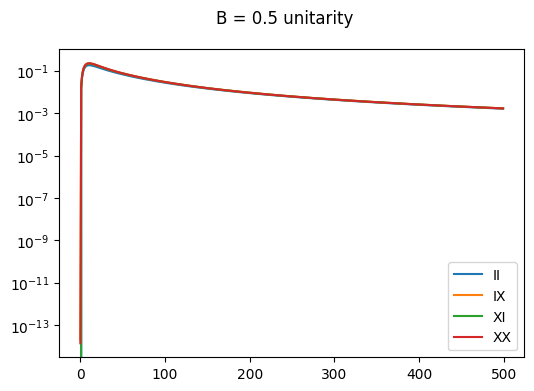

In [117]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(unitarity_scores[5], symmetry_labels):
    ax.plot(scores, label=label)

ax.set_yscale('log')
ax.legend()

fig.suptitle('B = 0.5 unitarity')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_67371/588135298.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


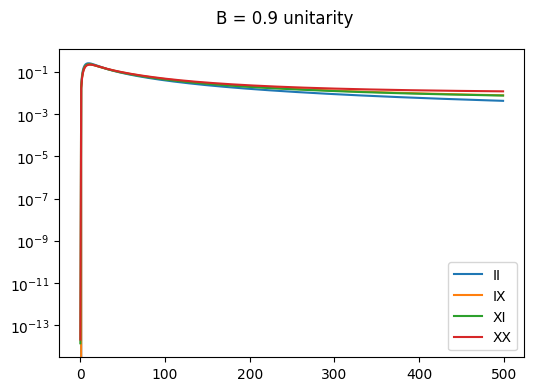

In [118]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(unitarity_scores[9], symmetry_labels):
    ax.plot(scores, label=label)

ax.set_yscale('log')
ax.legend()

fig.suptitle('B = 0.9 unitarity')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_67371/3623474513.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


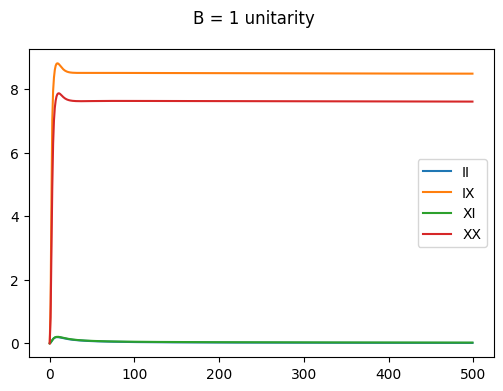

In [119]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(unitarity_scores[10], symmetry_labels):
    ax.plot(scores, label=label)

ax.legend()

fig.suptitle('B = 1 unitarity')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_67371/983117741.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


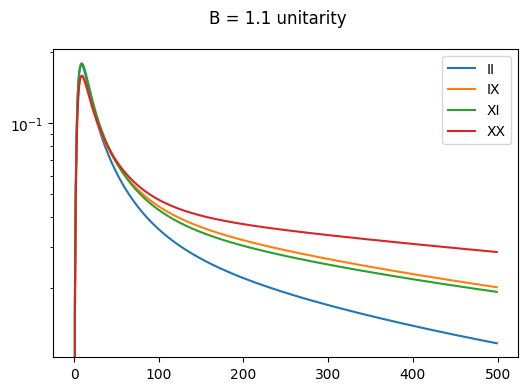

In [120]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(unitarity_scores[11], symmetry_labels):
    ax.plot(scores, label=label)

ax.set_yscale('log')
ax.legend()

fig.suptitle('B = 1.1 unitarity')
fig.show()

Generally converging, perhaps needs longer times? Or different learning rates.

## Overlaps

In [121]:
np.abs(np.array(overlap_scores)[:,:,-1])

array([[1.35665302, 1.35584583, 1.35680287, 1.35607302],
       [1.35678183, 1.35647471, 1.35635618, 1.35657191],
       [1.35680024, 1.35639308, 1.3561551 , 1.3561888 ],
       [1.35640988, 1.35654112, 1.35628462, 1.35665912],
       [1.35638479, 1.35685288, 1.35569526, 1.35630288],
       [1.35673489, 1.35553464, 1.35570324, 1.35557439],
       [1.35641313, 1.35395145, 1.35431966, 1.35327037],
       [1.35506296, 1.35004677, 1.35019573, 1.3460148 ],
       [1.35281927, 1.34323338, 1.34167038, 1.32681662],
       [1.34942223, 1.30944779, 1.31158102, 1.26435327],
       [1.09154987, 2.06125771, 1.02908713, 1.90228886],
       [1.06702014, 1.01808072, 1.02237861, 0.97583181],
       [1.01736368, 0.98795786, 1.00102564, 0.97566363],
       [0.9996852 , 0.98814244, 0.99225204, 0.97818774],
       [0.98223505, 0.98971426, 0.98872214, 0.98216049],
       [0.98244474, 0.97500759, 0.98150411, 0.98050198],
       [0.9789285 , 0.9855166 , 0.98867943, 0.98030895],
       [0.98270682, 0.981414  ,

In [122]:
sing_vals = [[c.symmetry_transfer_matrix_singular_vals[0] for c in l] for l in cases]

In [123]:
targets = np.array([[np.power(s, -1/2) for s in l] for l in sing_vals])

In [124]:
np.round(targets - np.abs(np.array(overlap_scores)[:,:,-1]), 3)

array([[0.058, 0.058, 0.057, 0.058],
       [0.057, 0.058, 0.058, 0.058],
       [0.057, 0.058, 0.058, 0.058],
       [0.058, 0.058, 0.058, 0.058],
       [0.058, 0.058, 0.059, 0.058],
       [0.058, 0.06 , 0.059, 0.06 ],
       [0.06 , 0.062, 0.062, 0.063],
       [0.064, 0.069, 0.069, 0.073],
       [0.072, 0.082, 0.083, 0.098],
       [0.087, 0.13 , 0.128, 0.179],
       [0.13 , 6.455, 0.193, 6.626],
       [0.132, 0.181, 0.177, 0.224],
       [0.126, 0.156, 0.142, 0.168],
       [0.111, 0.122, 0.118, 0.132],
       [0.106, 0.099, 0.1  , 0.106],
       [0.091, 0.098, 0.092, 0.093],
       [0.083, 0.076, 0.073, 0.081],
       [0.07 , 0.072, 0.067, 0.071],
       [0.062, 0.062, 0.063, 0.064],
       [0.054, 0.056, 0.058, 0.058],
       [0.051, 0.052, 0.053, 0.051]])

Generally pretty ok, but could be better.

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_67371/1457258723.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


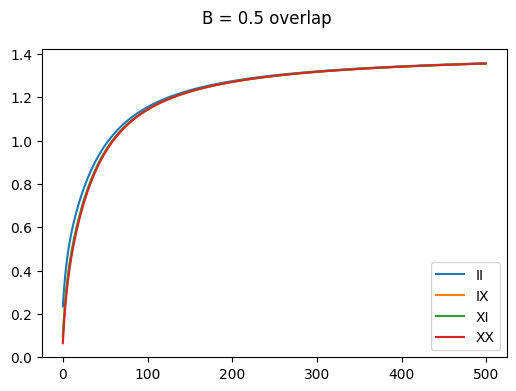

In [125]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(np.abs(overlap_scores[5]), symmetry_labels):
    ax.plot(scores, label=label)

ax.legend()

fig.suptitle('B = 0.5 overlap')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_67371/846040587.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


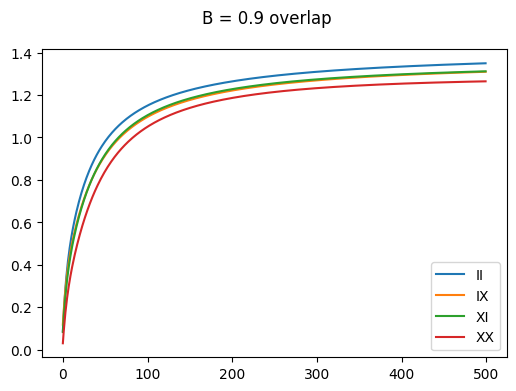

In [126]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(np.abs(overlap_scores[9]), symmetry_labels):
    ax.plot(scores, label=label)

ax.legend()

fig.suptitle('B = 0.9 overlap')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_67371/572593937.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


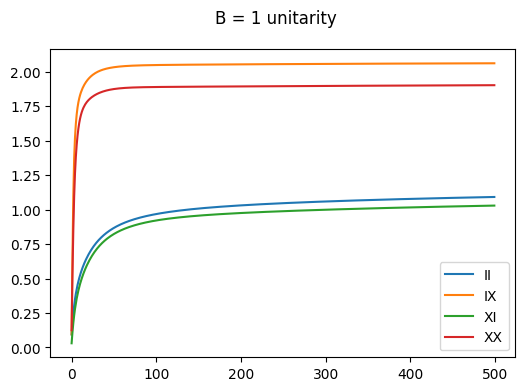

In [127]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(np.abs(overlap_scores[10]), symmetry_labels):
    ax.plot(scores, label=label)

ax.legend()

fig.suptitle('B = 1 unitarity')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_67371/1450865751.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


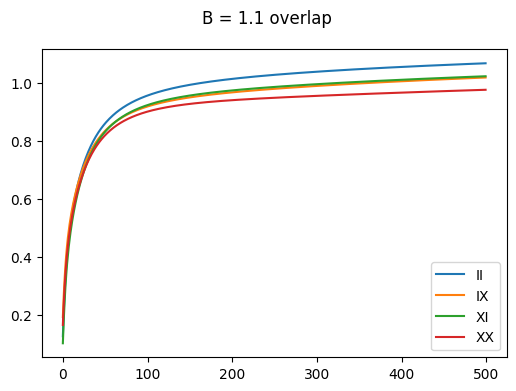

In [128]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(np.abs(overlap_scores[11]), symmetry_labels):
    ax.plot(scores, label=label)

ax.legend()

fig.suptitle('B = 1.1 overlap')
fig.show()

## Target score

In [129]:
np.array(target_scores)[:,:,-1]

array([[2.05011790e-04, 2.10775218e-04, 2.03946243e-04, 2.09144799e-04],
       [2.04104298e-04, 2.06283860e-04, 2.07128616e-04, 2.05594174e-04],
       [2.04096215e-04, 2.06989097e-04, 2.08690806e-04, 2.08446490e-04],
       [2.07442481e-04, 2.06501071e-04, 2.08329515e-04, 2.05655703e-04],
       [2.09339851e-04, 2.05967945e-04, 2.14283827e-04, 2.09862851e-04],
       [2.11050879e-04, 2.19643939e-04, 2.18409964e-04, 2.19214067e-04],
       [2.22903893e-04, 2.41024946e-04, 2.38206105e-04, 2.45809717e-04],
       [2.54677225e-04, 2.94341364e-04, 2.93078543e-04, 3.27780336e-04],
       [3.25538523e-04, 4.11475386e-04, 4.27297107e-04, 5.84680371e-04],
       [4.80158595e-04, 1.03824628e-03, 1.00520451e-03, 1.89208371e-03],
       [1.13198224e-03, 2.18741736e+00, 2.39741587e-03, 2.29201644e+00],
       [1.16586677e-03, 2.14417939e-03, 2.04501628e-03, 3.20371496e-03],
       [1.07604680e-03, 1.61894720e-03, 1.36179867e-03, 1.87197331e-03],
       [8.40932342e-04, 1.02058505e-03, 9.54000153e

These are all quite good. But the cost functions are quartic for unitaries and quadratic for the overlap. So it makes sense these are much smaller. Perhaps should renormalise somehow...?

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_67371/2222439871.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


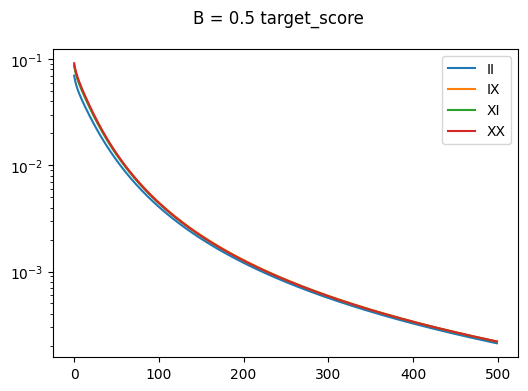

In [130]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(target_scores[5], symmetry_labels):
    ax.plot(scores, label=label)

ax.set_yscale('log')
ax.legend()

fig.suptitle('B = 0.5 target_score')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_67371/1728333252.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


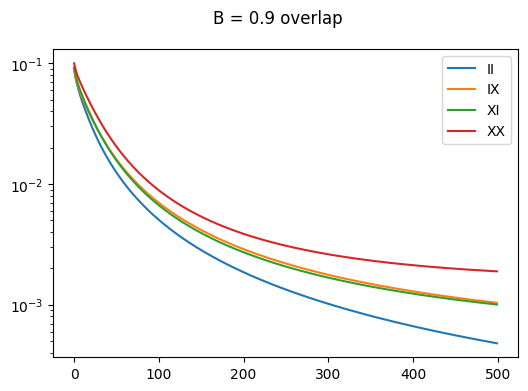

In [131]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(target_scores[9], symmetry_labels):
    ax.plot(scores, label=label)

ax.set_yscale('log')
ax.legend()

fig.suptitle('B = 0.9 overlap')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_67371/2192447709.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


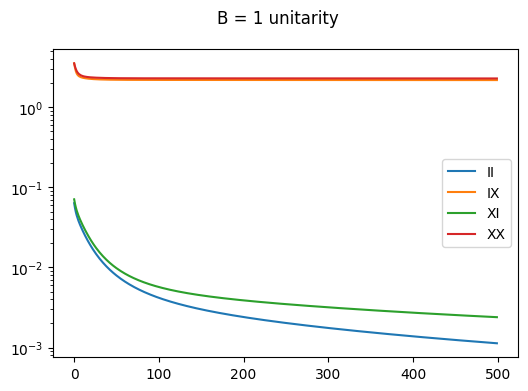

In [132]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(target_scores[10], symmetry_labels):
    ax.plot(scores, label=label)

ax.set_yscale('log')
ax.legend()

fig.suptitle('B = 1 unitarity')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_67371/3726596553.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


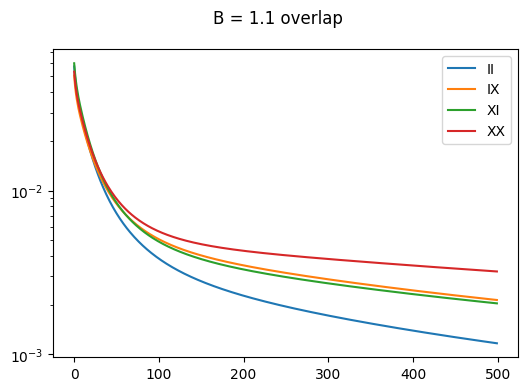

In [133]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(target_scores[11], symmetry_labels):
    ax.plot(scores, label=label)

ax.set_yscale('log')
ax.legend()

fig.suptitle('B = 1.1 overlap')
fig.show()

# Extract SPT phase

### Functions

In [134]:
from itertools import combinations

In [135]:
symmetry_combination_labels = list(combinations(symmetry_labels, 2))

In [136]:
symmetry_combination_labels

[('II', 'IX'),
 ('II', 'XI'),
 ('II', 'XX'),
 ('IX', 'XI'),
 ('IX', 'XX'),
 ('XI', 'XX')]

In [137]:
def get_reduced_tensor_matrix(symmetry_case, num_sites=NUM_SITES, normalise=False):
    mps_tensors = [
        symmetry_case.psi.get_B(i)
        for i in range(
            symmetry_case.right_symmetry_index + 1,
            symmetry_case.right_symmetry_index + 1 + num_sites
        )
    ]

    rdm = symmetry_case.right_projected_symmetry_state

    if normalise:
        normalisation = npc.trace(rdm, 'vR', 'vR*')
        norm_phase = normalisation/np.abs(normalisation)
    
        rdm *= norm_phase.conj()

    for i, b in enumerate(mps_tensors):
        b_current = b.replace_label('p', f'p{i}')
    
        rdm = npc.tensordot(rdm, b_current, [['vR'], ['vL']])
        rdm = npc.tensordot(rdm, b_current.conj(), [['vR*'], ['vL*']])
    
    rdm = npc.trace(rdm, 'vR', 'vR*')

    leg_labels = [f'p{i}' for i in range(num_sites)]
    leg_conj_labels = [f'p{i}*' for i in range(num_sites)]

    rdm = rdm.combine_legs([leg_labels, leg_conj_labels])

    return rdm

In [138]:
def get_grouped_leg_labels(num_sites):
    leg_labels = [f'p{i}' for i in range(num_sites)]
    leg_conj_labels = [f'p{i}*' for i in range(num_sites)]

    grouped_physical_leg_label = '(' + '.'.join(leg_labels) + ')'
    grouped_physical_leg_conj_label = '(' + '.'.join(leg_conj_labels) + ')'

    return (grouped_physical_leg_label, grouped_physical_leg_conj_label)

In [139]:
def multiply_tenpy_matrices(m1, m2, grouped_physical_leg_label='p',
                            grouped_physical_leg_conj_label='p*'):
    return npc.tensordot(
        m1,
        m2,
        [
            [grouped_physical_leg_label,],
            [grouped_physical_leg_conj_label,]
        ]
    )

In [140]:
def distance_from_identity(j, dim=2, grouped_physical_leg_label='p',
                            grouped_physical_leg_conj_label='p*'):
    # Assumes two dimensions

    p1 = grouped_physical_leg_label
    p2 = grouped_physical_leg_conj_label
    e1 = npc.tensordot(j, j.conj(), [[p1, p2], [p2, p1]])

    e2 = npc.trace(j, p1, p2)

    return e1 - 2*e2.real + dim

In [141]:
def gauge_invariant_phase(u1, u2, dim=2, grouped_physical_leg_label='p',
                            grouped_physical_leg_conj_label='p*'):
    def multiply(m1, m2):
        return multiply_tenpy_matrices(
            m1,
            m2,
            grouped_physical_leg_label,
            grouped_physical_leg_conj_label
        )

    u = reduce(multiply, [u1, u2, u1.conj(), u2.conj()])

    trace = npc.trace(
        u,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label
    )

    phase = trace/abs(trace)

    approx_identity = u/phase
    approx_identity_distance = distance_from_identity(
        approx_identity,
        dim,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label
    )

    return phase, approx_identity_distance

In [142]:
def state_gauge_invariant_phase(u1, u2, rdm_tensor, dim=2, grouped_physical_leg_label='p',
                            grouped_physical_leg_conj_label='p*'):
    def multiply(m1, m2):
        return multiply_tenpy_matrices(
            m1,
            m2,
            grouped_physical_leg_label,
            grouped_physical_leg_conj_label
        )

    t = reduce(multiply, [u1, u2, u1.conj(), u2.conj(), rdm_tensor])

    trace = npc.trace(
        t,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label
    )

    phase = trace/abs(trace)

    return phase

In [143]:
def get_state_phases(solutions, rdm_tensor, matrix_dim,
                     grouped_physical_leg_label,
                     grouped_physical_leg_conj_label):
    # To-do: Automatically get all info. Should only need cases input argument
    solution_pairs = combinations(solutions, 2)

    out = [
        state_gauge_invariant_phase(
            *p,
            rdm_tensor,
            matrix_dim,
            grouped_physical_leg_label,
            grouped_physical_leg_conj_label
        )
        for p in solution_pairs
    ]

    return out

## Calculation

In [144]:
grouped_physical_leg_label, grouped_physical_leg_conj_label = get_grouped_leg_labels(NUM_SITES)

In [145]:
phase_distance_pairs = [
    [
        gauge_invariant_phase(
            *p,
            matrix_dim,
            grouped_physical_leg_label,
            grouped_physical_leg_conj_label
        )
        for p in combinations(l, 2)
    ]
    for l in solutions
]

In [146]:
phases = [[p[0] for p in l] for l in phase_distance_pairs]
distances = [[p[1] for p in l] for l in phase_distance_pairs]

In [147]:
state_phases = list()

for l, c in zip(solutions, cases):
    rdm = get_reduced_tensor_matrix(c[0], NUM_SITES, normalise=True)

    state_data = get_state_phases(
        l,
        rdm,
        matrix_dim,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label
    )

    state_phases.append(state_data)

## Projective rep phases

In [148]:
np.round(phases[:10], 3)

array([[ 0.985-0.175j,  0.989-0.146j,  0.983+0.181j, -0.995-0.1j  ,
        -0.957+0.289j, -0.958-0.286j],
       [ 0.952-0.307j,  0.984-0.176j,  0.994+0.111j, -0.921-0.39j ,
        -1.   -0.026j, -0.978-0.208j],
       [ 0.962-0.272j,  0.983-0.182j,  0.961+0.276j, -0.92 +0.393j,
        -0.993+0.115j, -0.919-0.393j],
       [ 0.997+0.081j,  0.994-0.111j,  0.963-0.268j, -1.   -0.028j,
        -0.94 +0.34j , -0.986-0.165j],
       [ 0.978+0.211j,  1.   +0.01j ,  0.975+0.223j, -0.998+0.066j,
        -0.985+0.174j, -1.   +0.004j],
       [ 0.907-0.42j ,  0.979-0.202j,  0.992+0.128j, -0.958-0.286j,
        -0.906+0.424j, -0.941-0.338j],
       [ 0.999-0.043j,  0.981+0.194j,  0.926+0.378j, -0.989-0.148j,
        -0.983+0.182j, -1.   -0.018j],
       [ 0.969+0.245j,  0.996-0.088j,  0.971-0.239j, -1.   -0.015j,
        -1.   +0.026j, -0.997-0.074j],
       [ 0.992+0.128j,  0.849+0.528j,  0.996+0.085j, -0.985-0.174j,
        -0.993+0.114j, -0.968+0.249j],
       [ 0.972-0.237j,  0.988+0.157j,

In [149]:
phases[10]

[(0.9895595847200049-0.1441243500896757j),
 (0.9687136087534984-0.2481812728949825j),
 (0.9995881156833235-0.02869841432314076j),
 (-0.9963363794385959-0.0855208688402446j),
 (-0.9999937907179828-0.0035239928318793827j),
 (-0.9757005154603067+0.21910843007627961j)]

In [150]:
np.round(phases[11:], 3)

array([[ 0.975-0.222j,  0.887-0.461j,  0.933+0.36j ,  0.824-0.567j,
         0.998-0.067j,  0.872-0.489j],
       [ 0.942-0.335j,  0.987-0.162j,  0.99 -0.144j,  0.992-0.124j,
         0.721-0.693j,  0.84 +0.543j],
       [ 0.967-0.255j,  0.994-0.111j,  0.959-0.285j,  0.93 -0.367j,
         0.99 +0.138j,  0.807+0.591j],
       [ 0.167+0.986j,  0.965-0.261j,  0.723-0.691j,  0.998+0.059j,
         0.683-0.73j , -0.936-0.351j],
       [ 0.932-0.362j,  0.488-0.873j,  0.912-0.41j ,  0.872+0.489j,
         0.962-0.274j,  0.903-0.429j],
       [ 0.991+0.132j,  0.717-0.697j,  0.689-0.725j,  1.   +0.022j,
         0.95 +0.311j,  0.568+0.823j],
       [ 0.714+0.7j  ,  0.932+0.363j,  0.258-0.966j,  0.885+0.466j,
         0.911+0.412j,  0.774-0.634j],
       [ 0.995+0.099j,  0.999-0.052j,  0.48 +0.877j,  0.238+0.971j,
         0.777-0.63j ,  0.928+0.373j],
       [ 0.612+0.791j,  0.559-0.829j,  0.839+0.544j,  0.944+0.33j ,
         0.945+0.328j,  0.98 +0.198j],
       [ 0.841+0.542j,  0.983+0.182j,

## State phases

In [151]:
np.real(np.round(np.array(state_phases), 2))

array([[ 1.,  1.,  1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.]])

Looks good!

# Conclusions

* It works!
* Doesn't converge perfectly. Likely need random initialization, or better hyperparameters.
* In particular, the overlap isn't converging well. May need to increase the learning rate?